In [1]:
%load_ext autoreload
%autoreload 2

# Final Evaluation

We are using validation set from CityPersons as our test set because we have ground truths for it.

In [2]:
import os
import sys
import json
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Load data

In [3]:
## here I'm loading predictions from pickled predictions 
preds_path = '../data/predictions/predictions-fit1.pickle'

## we can also load the model and run it again on each image from the test set
# import torch
# from torchvision import transforms
# model = load_model('/home/marko/data/models/final-model-fit.pt') ...
# results are the same

In [4]:
## load ground truths (val_gt.json)
with open('../data/predictions/val_gt.json') as json_file:
    val_gt = json.load(json_file)

In [5]:
with open(preds_path, 'rb') as pickle_file:
    preds = pickle.load(pickle_file)

In [6]:
## intersect with our predictions (441 images)
val_imgs = val_gt['images']
val_imgs = [val_img['im_name'] for val_img in val_imgs]

pred_imgs = list(preds.keys())

imgs = list(set(val_imgs) & set(pred_imgs))
len(imgs)

441

In [7]:
## extract image ids
img_ids = []
for vgt in val_gt['images']:
    if vgt['im_name'] in imgs:
        img_ids.append(vgt['id'])

In [8]:
## subset val_gt and create test_gt
test_gt = {}
test_gt['categories'] = val_gt['categories']
test_gt['images'] = []
test_gt['annotations'] = []

for img in val_gt['images']:
    if img['im_name'] in imgs:
        test_gt['images'].append(img)

for anno in val_gt['annotations']:
    if anno['image_id'] in img_ids:
        
        ## add area to anno (needed for default pycocotools eval)
        bbox = anno['bbox']
        anno['area'] = int(bbox[2]) * int(bbox[3])
        
        test_gt['annotations'].append(anno)

In [9]:
## check
test_imgs = test_gt['images']
test_imgs = [test_img['im_name'] for test_img in test_imgs]
# test_imgs[:5], len(test_imgs)

In [10]:
test1_img = test_gt['images'][0]
img_name = test1_img['im_name']
img_id = test1_img['id']

## GT bboxes
bboxes = []
for anno in test_gt['annotations']:
    if anno['image_id'] == 1 and anno['category_id'] == 1 and anno['ignore'] == 0:
#         print(anno)
        bboxes.append(anno['bbox'])
# bboxes

In [11]:
# DT bboxes
bboxes_dt = np.round(preds[img_name]['boxes'])
bboxes_dt = bboxes_dt.tolist()

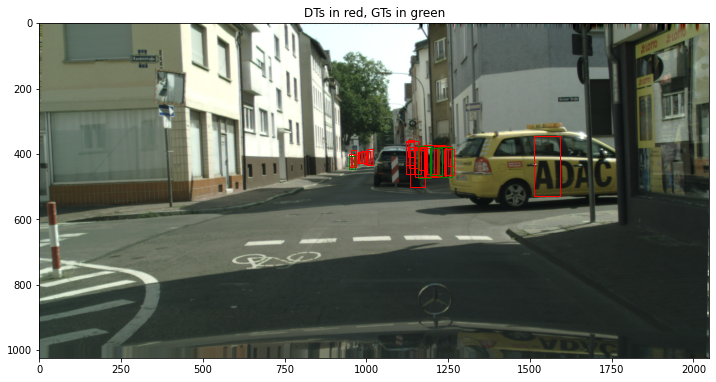

In [12]:
img = Image.open('../data/predictions/' + img_name)
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
ax.imshow(img);

for bbox in bboxes_dt:
    x1, y1, x2, y2 = bbox
    w, h = x2 - x1, y2 - y1
    rect = patches.Rectangle(
        (x1, y1), w, h,
        linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# bbox = [x, y, w, h]
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3],
        linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.title('DTs in red, GTs in green')
plt.show()

In [13]:
## we can save the test_gt as json
with open('../data/predictions/test_gt.json', 'w', encoding='utf-8') as json_file:
    json.dump(test_gt, json_file, ensure_ascii=False, indent=4)

In [14]:
## save img ids for detections json
get_id = {}
for img in test_gt['images']:
    get_id[img['im_name']] = img['id']

In [15]:
## double check
all_ids = []
for img in imgs: 
    all_ids.append(get_id[img])
assert sorted(all_ids) == sorted(img_ids)

In [16]:
## see loadRes() and loadNumpyAnnotations() from COCO Class
## we need to provide [imageID, x1, y1, w, h, score, class] for each bbox:
test_dt = []
for img in imgs:
    bboxes = preds[img]['boxes']
    scores = preds[img]['scores']
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        w, h = x2 - x1, y2 - y1
        data = [get_id[img], x1, y1, w, h, scores[i], 1]
        test_dt.append(data)
test_dt = np.array(test_dt)

In [17]:
## check
np.round(test_dt[0])

array([1.540e+02, 1.379e+03, 3.380e+02, 8.400e+01, 1.990e+02, 1.000e+00,
       1.000e+00])

In [18]:
## check
# should be a lot more detections than gt bboxes 
len(test_dt), len(test_gt['annotations'])

(24672, 5665)

In [19]:
print('About %.2f times more detected bboxes than there are gt bboxes' 
      % (len(test_dt) / len(test_gt['annotations'])))

About 4.36 times more detected bboxes than there are gt bboxes


# DEBUG

What I did:

* Converted CityPersons scripts in `eval_script` from Python2 to Python3 using `2to3 . -w .` in `./eval_script`
* I compared the code and why did you divide `gt['vis_ratio']` by 100?

# Evaluate

In [21]:
## Citypersons average miss rate measures
module_path = os.path.abspath(os.path.join('../src/eval_script/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from coco import COCO
from eval_MR_multisetup import COCOeval

annType = 'bbox'
annFile = '../data/predictions/test_gt.json'
resFile = test_dt

res_file_path = '../data/predictions/results.txt'
res_file = open(res_file_path, 'w')

for id_setup in range(0, 4):
    cocoGt = COCO(annFile)
    cocoDt = cocoGt.loadRes(resFile)
    imgIds = sorted(cocoGt.getImgIds())
    cocoEval = COCOeval(cocoGt, cocoDt, annType)
    cocoEval.params.imgIds = imgIds
    cocoEval.evaluate(id_setup)
    cocoEval.accumulate()
    cocoEval.summarize(id_setup, res_file)

res_file.close()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(24672, 7)
0/24672
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.78s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Miss Rate  (MR) @ Reasonable         [ IoU=0.50      | height=[50:10000000000] | visibility=[0.65:10000000000.00] ] = 24.73%
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(24672, 7)
0/24672
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.13s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Miss Rate  (MR) @ Reasonable_small   [ IoU=0.50      | height=[50:75] | visibility=[0.65:10000000000.00] ] = 47.35%
loading annotations into memory...
Done (t=0.02s)
c

In [64]:
## making the printout nicer..
print('Results: ')
res_file = open(res_file_path,'r')
lines = res_file.readlines()
res_file.close()
lines = [line.replace('10000000000.00', 'inf') for line in lines]
lines = [line.replace('10000000000', 'inf') for line in lines]
lines = [line.strip() for line in lines]
for line in lines:
    new = ''
    for elt in line.split(' '):
        if elt:
            new += elt + ' '
    print(new)

Results: 
Average Miss Rate (MR) @ Reasonable [ IoU=0.50 | height=[50:inf] | visibility=[0.65:inf] ] = 24.73% 
Average Miss Rate (MR) @ Reasonable_small [ IoU=0.50 | height=[50:75] | visibility=[0.65:inf] ] = 47.35% 
Average Miss Rate (MR) @ Reasonable_occ=heavy [ IoU=0.50 | height=[50:inf] | visibility=[0.20:0.65] ] = 64.74% 
Average Miss Rate (MR) @ All [ IoU=0.50 | height=[20:inf] | visibility=[0.20:inf] ] = 52.72% 


In [63]:
## rewrite as a row to add it to the benchmark table
results = [line.split('=')[-1] for line in lines]
results = [line.split('=')[-1] for line in lines]
results.insert(0, ' × ')
results.insert(0, ' Our FasterRCNN ')
results = [('**' + result.strip() + '**') for result in results]
results = ' | '.join(results)
results = ' | ' + results + ' | '
results

' | **Our FasterRCNN** | **×** | **24.73%** | **47.35%** | **64.74%** | **52.72%** | '

### Benchmark ###

|         Method         | External   training data | MR (Reasonable) | MR (Reasonable_small) | MR (Reasonable_occ=heavy) | MR (All) |
|:----------------------:|:----------------------:|:---------------:|:---------------------:|:-------------------------:|:--------:|
| [APD-pretrain](https://arxiv.org/abs/1910.09188) |  √ |      7.31%     |         10.81%        |           28.07%          |  32.71%  |
| [Pedestron](https://arxiv.org/abs/2003.08799) |  √ |      7.69%     |         9.16%        |           27.08%          |  28.33%  |
| [APD](https://arxiv.org/abs/1910.09188) |  ×  |      8.27%     |         11.03%        |           35.45%          |  35.65%  |
| YT-PedDet |  ×  |      8.41%     |         10.60%        |           37.88%          |  37.22%  |
| STNet |  ×  |      8.92%     |         11.13%        |           34.31%          |  29.54%  |
| [MGAN](https://arxiv.org/abs/1910.06160) |  ×  |      9.29%     |         11.38%        |           40.97%          |  38.86%  |
| DVRNet |  ×  |      11.17%     |         15.62%        |           42.52%          |  40.99%  |
| [HBA-RCNN](https://arxiv.org/abs/1911.11985) |  ×  |      11.26%     |         15.68%        |           39.54%          |  38.77%  |
| [OR-CNN](https://arxiv.org/abs/1807.08407)     |  ×  |      11.32%     |         14.19%        |           51.43%          |  40.19%  |
| [AdaptiveNMS](http://openaccess.thecvf.com/content_CVPR_2019/papers/Liu_Adaptive_NMS_Refining_Pedestrian_Detection_in_a_Crowd_CVPR_2019_paper.pdf)     |  ×  |      11.40%     |         13.64%        |           46.99%          |  38.89%  |
| [Repultion Loss](http://arxiv.org/abs/1711.07752)     |  ×  |      11.48%     |         15.67%        |           52.59%          |  39.17%  |
| [Cascade MS-CNN](https://arxiv.org/abs/1906.09756)     |  ×  |      11.62%     |         13.64%        |           47.14%          |  37.63%  |
| [Adapted FasterRCNN](http://202.119.95.70/cache/12/03/openaccess.thecvf.com/f36bf52f1783160552c75ae3cd300e84/Zhang_CityPersons_A_Diverse_CVPR_2017_paper.pdf)  |  ×  |      12.97%     |         37.24%        |           50.47%          |  43.86%  |
| [MS-CNN](https://arxiv.org/abs/1607.07155)     |  ×  |      13.32%     |         15.86%        |           51.88%          |  39.94%  |
| **Our FasterRCNN** | **×** | **24.73%** | **47.35%** | **64.74%** | **52.72%** | 

In [23]:
## Test using default pycocotools measures
module_path = os.path.abspath(os.path.join('../src/pycocotools/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from coco import COCO
from cocoeval import COCOeval

annType = 'bbox'
annFile = '../data/predictions/test_gt.json'
resFile = test_dt

cocoGt=COCO(annFile)
cocoDt = cocoGt.loadRes(resFile)

imgIds = sorted(cocoGt.getImgIds())
cocoEval = COCOeval(cocoGt, cocoDt, annType)

cocoEval.params.imgIds = imgIds
cocoEval.evaluate()

cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(24672, 7)
0/24672
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.99s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.579
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.251
 Average Recall

## TODOs:

1. Why did we get worst results here compared to results on the cloud. Using `evaluate(model, data_loader_test, device=device)` when testing on the same set:

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.668
```